## 2D attempt at solving the bidomain equations:

In [1]:
from fenics import *
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

### Generating a mesh:

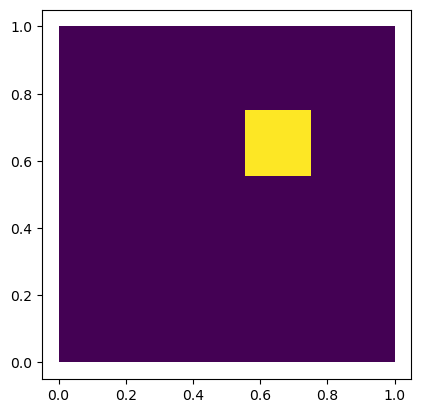

In [12]:
mesh, cellfunction, facetfunction = mesh_maker()
plot(cellfunction)

### Bidomain model:

In [3]:
# Define function space
P1 = FiniteElement("P", triangle, 2)
element = MixedElement([P1, P1, P1])
V = FunctionSpace(mesh, element)
V1 = FunctionSpace(mesh, P1)

# Define test functions
phi, psi, theta = TestFunctions(V)

# Define functions
v = Function(V)
v_n = Function(V)

V_m, u, w = split(v)
V_m_n, u_n, w_n = split(v_n)

In [4]:
# defining expressions for later use

# V_m = v[0], u = v[1], w = v[2]
# Ionic current
I_ion = Expression(
    "-v[2]/TAU_IN*pow((v[0] - V_MIN),2)*(V_MAX - v[0])/(V_MAX - V_MIN) + 1/TAU_OUT*(v[0] - V_MIN)/(V_MAX - V_MIN)",
    TAU_IN=TAU_IN,
    TAU_OUT=TAU_OUT,
    V_MIN=V_MIN,
    V_MAX=V_MAX,
    v=v,
    degree=2,
)
# Gating variable
g = Expression(
    "v[0] < V_GATE ? v[2]/TAU_OPEN - 1/TAU_OPEN/pow((V_MAX - V_MIN),2) : v[2]/TAU_CLOSE",
    TAU_OPEN=TAU_OPEN,
    TAU_CLOSE=TAU_CLOSE,
    V_GATE=V_GATE,
    V_MAX=V_MAX,
    V_MIN=V_MIN,
    v=v,
    degree=2,
)
# Fiber vector field
fibers = Expression(
    (
        "x[1]/sqrt(pow(x[0],2) + pow(x[1],2) + DOLFIN_EPS)",
        "-x[0]/sqrt(pow(x[0],2) + pow(x[1],2) + DOLFIN_EPS)",
    ),
    degree=2,
)
# Applied stimulus
I_app = Expression(
    "exp(-pow(x[0]-X, 2)/size - pow(x[1]-Y, 2)/size - pow(t/t_act, 2))",
    X=X,
    Y=Y,
    t_act=T_ACT,
    t=0,
    size=(X + Y) / 2,
    degree=2,
)  # nije kao u radu

In [5]:
# defining UFL language parts

# conductivities
sigma_il = Constant(SIGMA_IL)
sigma_it = Constant(SIGMA_IT)
sigma_el = Constant(SIGMA_EL)
sigma_et = Constant(SIGMA_ET)
sigma_tlt = Constant(SIGMA_TLT)

d = mesh.topology().dim()

sigma_i = sigma_it * Identity(d) + (sigma_il - sigma_it) * outer(fibers, fibers)
sigma_e = sigma_et * Identity(d) + (sigma_el - sigma_et) * outer(fibers, fibers)
sigma_t = sigma_tlt * Identity(d)

# Constants used in variational forms
dt = Constant(DT)
A_m = Constant(A_M)
C_m = Constant(C_M)

In [6]:
# Define new measures associated with the interior domains and
# exterior boundaries
dx = Measure("dx")(subdomain_data=cellfunction)
ds = Measure("ds")(subdomain_data=facetfunction)

In [7]:
# Define variational problem
F = (
    A_m * (C_m * (V_m - V_m_n) + dt * I_ion) * phi * dx(1)
    + dt * inner(dot(sigma_i, grad(V_m + u)), grad(phi)) * dx(1)
    - dt * A_m * I_app * phi * dx(1)
)
F += (
    inner(dot(sigma_i + sigma_e, grad(u)), grad(psi)) * dx(1)
    + inner(dot(sigma_i, grad(V_m)), grad(psi)) * dx(1)
    + inner(dot(sigma_t, grad(u)), grad(psi)) * dx(0)
)
F += (w - w_n + dt * g) * theta * dx(1)

In [8]:
# Initial conditions
V_m_0 = Expression("V_MIN", V_MIN=V_MIN, degree=0)
w_0 = Expression("1/pow((V_MAX - V_MIN), 2)", V_MIN=V_MIN, V_MAX=V_MAX, degree=0)

V_m_n, u_n, w_n = v_n.split(deepcopy=True)
V_m, u, w = v.split(deepcopy=True)

V_m_n = project(V_m_0, V1)
w_n = project(w_0, V1)

In [9]:
# Time-stepping
t = 0
for n in tqdm(range(NUM_STEPS)):
    # Update current time and expressions
    t += DT
    g.v = v
    I_ion.v = v
    I_app.t = t

    # Solve variational problem for time step
    # set_log_active(False)
    solver = custom_solver(F, v, tol_abs=1e-2, tol_rel=1e-2, max_iter=10)
    solver.solve()

    # Update previous solution
    v_n.assign(v)

  2%|▎         | 2/80 [00:00<00:08,  8.81it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.825e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.814e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


  5%|▌         | 4/80 [00:00<00:08,  8.65it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.795e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.768e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


  8%|▊         | 6/80 [00:00<00:08,  8.49it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.733e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.692e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 10%|█         | 8/80 [00:00<00:08,  8.43it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.643e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.587e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.524e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 14%|█▍        | 11/80 [00:01<00:08,  8.40it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.454e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.378e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.296e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 18%|█▊        | 14/80 [00:01<00:07,  8.49it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.209e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.115e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.017e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 21%|██▏       | 17/80 [00:02<00:07,  8.27it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.914e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.806e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 24%|██▍       | 19/80 [00:02<00:07,  8.23it/s]


  Newton iteration 0: r (abs) = 4.694e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.579e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.460e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 28%|██▊       | 22/80 [00:02<00:06,  8.31it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.338e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.213e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 30%|███       | 24/80 [00:02<00:06,  8.17it/s]


  Newton iteration 0: r (abs) = 4.086e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.957e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 32%|███▎      | 26/80 [00:03<00:06,  8.25it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.827e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.696e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.563e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 36%|███▋      | 29/80 [00:03<00:06,  8.20it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.431e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.298e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.166e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 41%|████▏     | 33/80 [00:03<00:05,  8.25it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.034e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.903e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.773e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 44%|████▍     | 35/80 [00:04<00:05,  8.38it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.644e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.518e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 46%|████▋     | 37/80 [00:04<00:05,  8.39it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.393e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.270e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 49%|████▉     | 39/80 [00:04<00:04,  8.34it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.150e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.032e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 51%|█████▏    | 41/80 [00:04<00:04,  7.90it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.917e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.804e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 55%|█████▌    | 44/80 [00:05<00:04,  8.24it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.695e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.589e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.486e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 57%|█████▊    | 46/80 [00:05<00:04,  8.38it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.387e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.291e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 60%|██████    | 48/80 [00:05<00:03,  8.54it/s]


  Newton iteration 0: r (abs) = 1.198e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.109e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.023e-03 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 65%|██████▌   | 52/80 [00:06<00:03,  8.14it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 9.410e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.624e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 68%|██████▊   | 54/80 [00:06<00:03,  8.32it/s]


  Newton iteration 0: r (abs) = 7.873e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.158e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.478e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.834e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 72%|███████▎  | 58/80 [00:06<00:02,  8.24it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.225e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.651e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 75%|███████▌  | 60/80 [00:07<00:02,  7.40it/s]


  Newton iteration 0: r (abs) = 4.113e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.611e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.146e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 78%|███████▊  | 62/80 [00:07<00:02,  7.75it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.720e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.336e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 80%|████████  | 64/80 [00:07<00:02,  7.68it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.000e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.719e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 82%|████████▎ | 66/80 [00:08<00:01,  7.93it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.503e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.363e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.304e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 86%|████████▋ | 69/80 [00:08<00:01,  8.09it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.320e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.396e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.

 89%|████████▉ | 71/80 [00:08<00:01,  7.87it/s]


  Newton iteration 0: r (abs) = 1.511e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.649e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 91%|█████████▏| 73/80 [00:08<00:00,  8.14it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.797e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.948e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 94%|█████████▍| 75/80 [00:09<00:00,  8.31it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.097e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.240e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 96%|█████████▋| 77/80 [00:09<00:00,  8.39it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.377e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.506e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


 99%|█████████▉| 79/80 [00:09<00:00,  8.33it/s]

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.628e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.741e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.846e-04 (tol = 1.000e-02) r (rel) = 1.000e+00 (tol = 1.000e-02)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


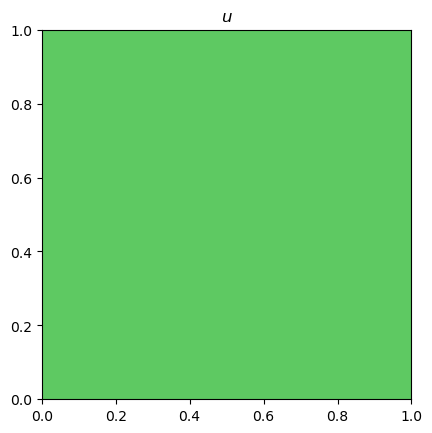

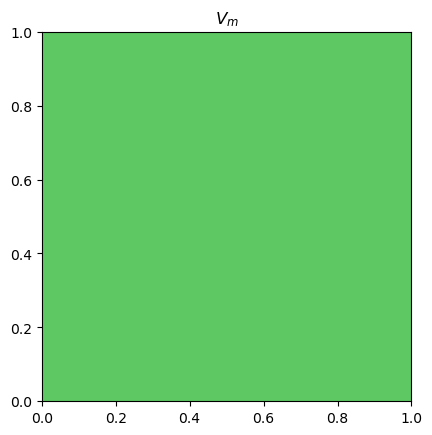

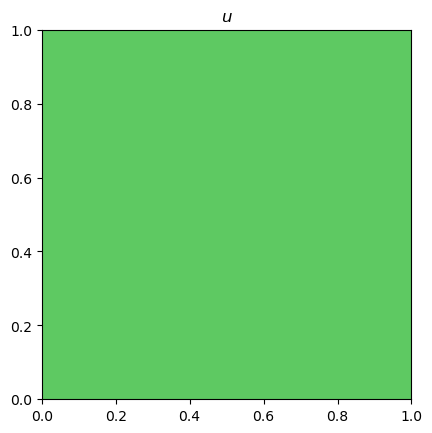

In [10]:
# Plot solution and gradient
plot(V_m, title="$V_m$")
plot(u, title="$u$")
plot(w, title="$w$")